# Use this notebook for experimentation

In [1]:
# Automatically re-import files when updated
%load_ext autoreload
%autoreload 2  
# Load packages
from models import *
from utils import *
from matplotlib import pyplot as plt
import time, json, pandas as pd, IPython

2023-10-11 20:24:40.473139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 20:24:40.636305: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 20:24:42.967442: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 20:24

In [4]:
# Load models
with tf.keras.utils.custom_object_scope({
    'Inception': Inception,
    "downsampler": downsampler,
    "upsampler": upsampler
    }):
    decoder = tf.keras.models.load_model("decoder.keras")
    encoder = tf.keras.models.load_model("encoder.keras")
    classifier = tf.keras.models.load_model("classifier.keras")

In [23]:
# Get data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
# Convert to tf dataset 
data_train = dataset_from_arrays(X_train, y_train)
data_test = dataset_from_arrays(X_test, y_test)

# Initialize scores
correct_original = 0
correct_reconstructed = 0
correct_adv = 0
# Loop over batches and predict
for i, (imgs, labels) in enumerate(data_test):
    if i==len(X_train)/BATCH_SIZE:
        break
    # For originals
    original_predictions = classifier(imgs)
    correct_original += tf.reduce_sum(tf.cast(tf.argmax(original_predictions, axis=1)==tf.argmax(labels, axis=1), dtype=tf.int32))
    # For adversarials
    adv_imgs = fgsm(classifier, tf.keras.losses.CategoricalCrossentropy(), imgs, labels)
    adv_predictions = classifier(adv_imgs)
    correct_adv += tf.reduce_sum(tf.cast(tf.argmax(adv_predictions, axis=1)==tf.argmax(labels, axis=1), dtype=tf.int32))
    # For reconstructions
    z = encoder(adv_imgs)
    reconstructed = decoder(z)
    predictions = classifier(reconstructed)
    correct_reconstructed += tf.reduce_sum(tf.cast(tf.argmax(predictions, axis=1)==tf.argmax(labels, axis=1), dtype=tf.int32))

    # Plot
    for (adv_img, rec, label, pred, adv_pred) in zip(adv_imgs, reconstructed, labels, predictions, adv_predictions):
        # Clear display
        IPython.display.clear_output()
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2)
        # Plot the original image
        ax1.imshow(adv_img)
        ax1.set_title("Adversarial example")
        ax1.axis('off')
        # Plot the reconstructed image
        ax2.imshow(rec)
        ax2.set_title("Reconstructed image")
        ax2.axis('off')
        # Add context
        print(f"True label: {tf.math.argmax(label).numpy()}\
                \nPredicted label on adversarial example: {tf.math.argmax(adv_pred).numpy()}\
                \nPredicted label on reconstructed image: {tf.math.argmax(pred).numpy()}")
        # Show for some time
        plt.show()
        time.sleep(2)

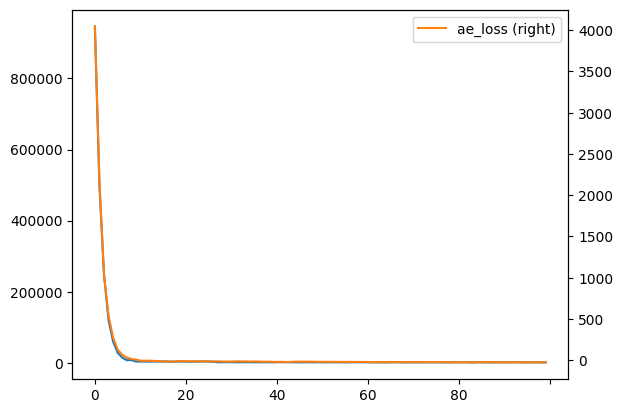

In [6]:
# Plot training progress
history = json.load(open("history.json", mode="r"))
history = pd.DataFrame.from_dict(history, orient="index")
history["classifier_loss"].plot();
history["ae_loss"].plot(secondary_y=True);
plt.legend();